# Errors in Anisotropy Estimation

As in every image analysis pipeline, there are several possible errors that contribute to its wrong estimation. Understanding the effects of each kind of error will help us find the adequate corrections for them. We will analyze here the following sources:

- Errors in Intensity Estimation
- Errors in shift registration

## Errors in Intensity Estimation

Adequate intensity estimation requires that the images are corrected for inhomogeneities in illumination and background. What are the effects of imperfect corrections of these sources? How are these appreciated in experiments?

In [1]:
from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np

import anisotropy_functions as af
from cell_sim import Cell, Biosensor, Microscope, Corrector

In [2]:
@interact(I_factor=(0, 2, 0.1), 
          a_dimer=(0, 0.4, 0.02), a_monomer=(0, 0.4, 0.02), 
          e_par=(-400, 400, 50), e_per=(-400, 400, 50))
def plot(I_factor=0.3, a_dimer=0.22, a_monomer=0.3, e_par=-400, e_per=-400):
    monomer_fraction = 1 / (1 + np.exp(-np.arange(-50, 50)/6))
    anisotropy = af.anisotropy_from_monomer(monomer_fraction, a_monomer, a_dimer, 1)
    total_fluo = af.total_fluorescence_from_monomer(monomer_fraction, 1, I_factor)
    I_parallel = af.intensity_parallel_from_anisotropy(anisotropy, total_fluo)
    I_perpendicular = af.intensity_perpendicular_from_anisotropy(anisotropy, total_fluo)
    anisotropy_from_int = af.anisotropy_from_intensity(I_parallel + e_par, 
                                                       I_perpendicular + e_per)
    
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(5, 7))
    
    axs[0].plot(I_parallel, c='g', label='Parallel')
    axs[0].plot(I_perpendicular, c='b', label='Perpendicular')
    axs[0].legend()
    axs[0].set_ylabel('Intensity')
    
    axs[1].axhline(y=a_dimer, color='k', ls='--')
    axs[1].axhline(y=a_monomer, color='k', ls='--')
    axs[1].plot(anisotropy_from_int, color='r', label='Estimated')
    axs[1].plot(anisotropy, color='r', alpha=0.5, label='Objective')
    axs[1].set_ylabel('Anisotropy')
    axs[1].legend()

    plt.subplots_adjust(hspace=0)
    plt.show()

interactive(children=(FloatSlider(value=0.3, description='I_factor', max=2.0), FloatSlider(value=0.22, descrip…

It is important to notice that there different monomer and dimer anisotropies are possible depending on the errors. We must highlight that in some cases monomer anisotropy might be higher than dimer anisotropy, and this looks like a reversed anisotropy curve. Aditionally, theoritacally impossible values are also possible depending on the magnitude of the errors. Furthermore, if the error in intensity has a time dependance this will affect the shape of the curve. 

## Errors in shift registration

Due to the thickness of high quality polarizers, it is likely that parallel and perpendicular images are shifted between each other. If we were to generate an anisotropy image, we need to be able to correct this shift. What happens if this is not adequately corrected? How can we bypass these problems? How can we estimate the best correction?

Let's begin by generating a simulated squared cell with a gradient of concentration of biosensors. We can choose the maximum number of biosensors expected and if we are to add poisson noise to this number.

In [3]:
proteins = 800
poisson = True

cell = Cell(proteins, poisson)

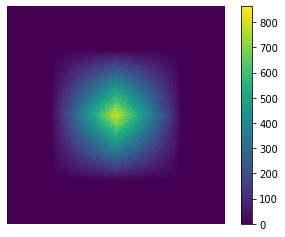

In [4]:
plt.imshow(cell.cell_image)
plt.colorbar()
plt.axis('off')
plt.show()

Let's define an anisotropy state for the cell.

In [5]:
anisotropy = 0.26
cell.add_biosensor({'anisotropy_monomer':0.3, 'anisotropy_dimer': 0.22, 'delta_b': 0.15})

cell.generate_intensity_images(anisotropy)

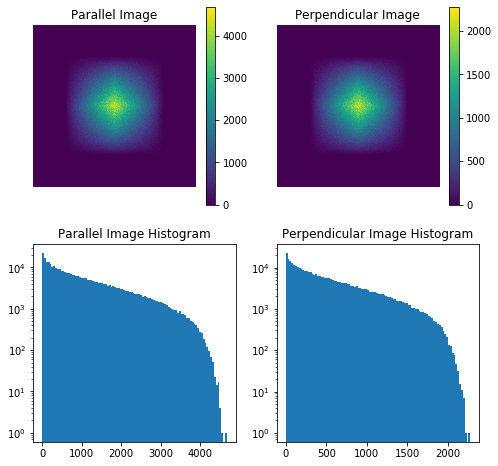

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()

this_im = axs[0].imshow(cell.parallel_image, interpolation='none')
fig.colorbar(this_im, ax=axs[0])

axs[0].axis('off')
axs[0].set_title('Parallel Image')

this_im = axs[1].imshow(cell.perpendicular_image, interpolation='none')
fig.colorbar(this_im, ax=axs[1])

axs[1].axis('off')
axs[1].set_title('Perpendicular Image')

axs[2].hist(cell.parallel_image[200:800, 200:800].flatten(), bins=100, log=True)
axs[2].set_title('Parallel Image Histogram')

axs[3].hist(cell.perpendicular_image[200:800, 200:800].flatten(), bins=100, log=True)
axs[3].set_title('Perpendicular Image Histogram')

plt.show()

We should estimate now the anisotropy image before adding acquisition noise.

In [7]:
non_acquired_anisotropy_image = np.zeros_like(cell.parallel_image)
nonzeros = np.nonzero(cell.parallel_image)
non_acquired_anisotropy_image[nonzeros] = af.anisotropy_from_intensity(cell.parallel_image[nonzeros], cell.perpendicular_image[nonzeros])

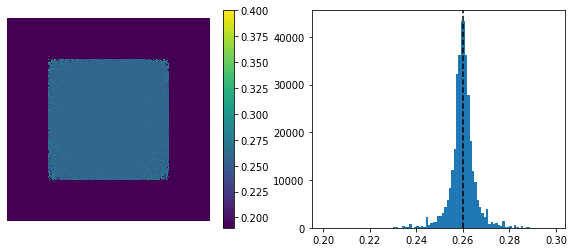

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

this_im = axs[0].imshow(non_acquired_anisotropy_image, vmin=0.19, vmax=0.4, interpolation='none')
axs[0].axis('off')
fig.colorbar(this_im, ax=axs[0])

axs[1].hist(non_acquired_anisotropy_image[200:800, 200:800].flatten(), bins=np.arange(0.2, 0.3, 0.001))
axs[1].axvline(x=anisotropy, color='k', ls='--')

plt.show()

After obtaining both intensity images, we could add some aquisition noise to the images.

In [9]:
microscope = Microscope()

parallel_image, perpendicular_image = microscope.acquire_cell(cell)

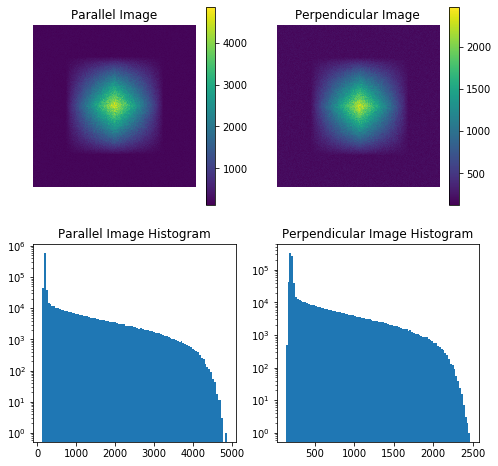

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()

this_im = axs[0].imshow(parallel_image, interpolation='none')
fig.colorbar(this_im, ax=axs[0])

axs[0].axis('off')
axs[0].set_title('Parallel Image')

this_im = axs[1].imshow(perpendicular_image, interpolation='none')
fig.colorbar(this_im, ax=axs[1])

axs[1].axis('off')
axs[1].set_title('Perpendicular Image')

axs[2].hist(parallel_image.flatten(), bins=100, log=True)
axs[2].set_title('Parallel Image Histogram')

axs[3].hist(perpendicular_image.flatten(), bins=100, log=True)
axs[3].set_title('Perpendicular Image Histogram')

plt.show()

In [11]:
anisotropy_image = np.zeros_like(parallel_image)
nonzeros = np.nonzero(parallel_image)
anisotropy_image[nonzeros] = af.anisotropy_from_intensity(parallel_image[nonzeros], perpendicular_image[nonzeros])

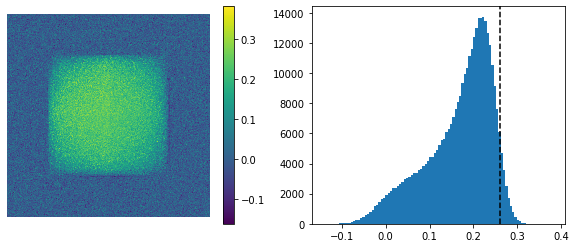

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

this_im = axs[0].imshow(anisotropy_image, interpolation='none')
axs[0].axis('off')
fig.colorbar(this_im, ax=axs[0])

axs[1].hist(anisotropy_image[200:800, 200:800].flatten(), bins=100)
axs[1].axvline(x=anisotropy, color='k', ls='--')

plt.show()

Now we need to add the image analysis steps and corrections we would normally implement to test them and choose the best option.

In [13]:
corrector = Corrector()
corrected_parallel, corrected_perpendicular = corrector.correct(parallel_image, perpendicular_image)

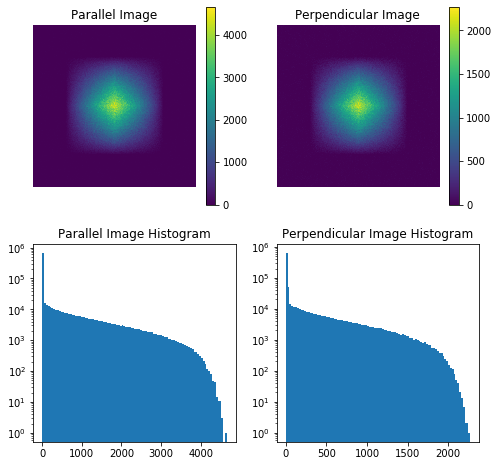

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()

this_im = axs[0].imshow(corrected_parallel, interpolation='none')
fig.colorbar(this_im, ax=axs[0])

axs[0].axis('off')
axs[0].set_title('Parallel Image')

this_im = axs[1].imshow(corrected_perpendicular, interpolation='none')
fig.colorbar(this_im, ax=axs[1])

axs[1].axis('off')
axs[1].set_title('Perpendicular Image')

axs[2].hist(corrected_parallel.flatten(), bins=100, log=True)
axs[2].set_title('Parallel Image Histogram')

axs[3].hist(corrected_perpendicular.flatten(), bins=100, log=True)
axs[3].set_title('Perpendicular Image Histogram')

plt.show()

In [15]:
corrected_anisotropy_image = np.zeros_like(corrected_parallel)
nonzeros = np.nonzero(corrected_parallel)
corrected_anisotropy_image[nonzeros] = af.anisotropy_from_intensity(corrected_parallel[nonzeros], corrected_perpendicular[nonzeros])

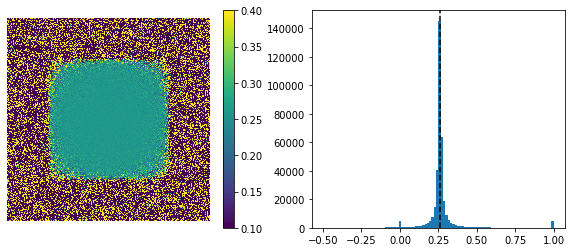

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

this_im = axs[0].imshow(corrected_anisotropy_image, vmin=0.1, vmax=0.4, interpolation='none')
axs[0].axis('off')
fig.colorbar(this_im, ax=axs[0])

axs[1].hist(corrected_anisotropy_image[200:800, 200:800].flatten(), bins=100)
axs[1].axvline(x=anisotropy, color='k', ls='--')

plt.show()

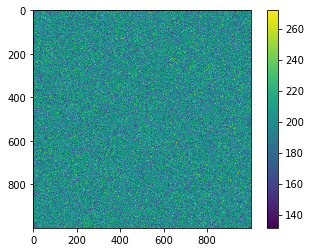

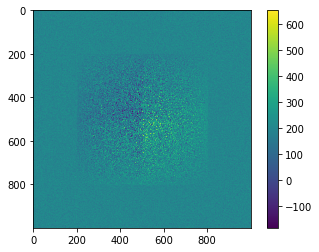

In [19]:
plt.imshow(parallel_image - cell.parallel_image)
plt.colorbar()
plt.show()

plt.imshow(perpendicular_image - cell.perpendicular_image)
plt.colorbar()
plt.show()

(array([3.000e+00, 0.000e+00, 0.000e+00, 5.000e+00, 4.000e+00, 6.000e+00,
        9.000e+00, 1.300e+01, 7.000e+00, 1.800e+01, 2.500e+01, 4.000e+01,
        4.700e+01, 7.100e+01, 9.300e+01, 1.370e+02, 1.470e+02, 2.010e+02,
        2.210e+02, 2.840e+02, 3.840e+02, 4.600e+02, 5.540e+02, 6.320e+02,
        8.380e+02, 1.025e+03, 1.145e+03, 1.408e+03, 1.677e+03, 1.875e+03,
        2.252e+03, 2.557e+03, 2.907e+03, 3.228e+03, 3.637e+03, 4.022e+03,
        4.414e+03, 4.824e+03, 5.185e+03, 5.540e+03, 5.957e+03, 6.236e+03,
        6.558e+03, 6.671e+03, 6.839e+03, 7.063e+03, 7.196e+03, 7.363e+03,
        7.132e+03, 7.130e+03, 7.047e+03, 6.667e+03, 6.491e+03, 6.051e+03,
        5.904e+03, 5.635e+03, 5.242e+03, 4.758e+03, 4.399e+03, 3.997e+03,
        3.599e+03, 3.220e+03, 2.863e+03, 2.527e+03, 2.192e+03, 1.932e+03,
        1.662e+03, 1.413e+03, 1.171e+03, 1.036e+03, 8.030e+02, 7.180e+02,
        5.550e+02, 4.630e+02, 3.540e+02, 2.940e+02, 2.100e+02, 1.690e+02,
        1.430e+02, 1.020e+02, 9.100e+0

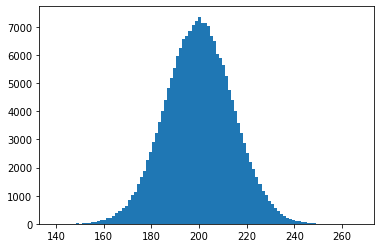

In [18]:
plt.hist(parallel_image[0:200, :].flatten(), bins=100)